<a href="https://colab.research.google.com/github/jdasam/mas1004-2023/blob/main/live_coding/3_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification
- In this notebook, we will practice binary classification using 2D inputs

In [92]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import torch
torch.set_printoptions(sci_mode=False) # to print 1e-04 as 0.0001

## 1. Generate Dataset

### 1-1 XOR Gate
- XOR Gate is true when the two inputs are different and false when the two inputs are same
  - XOR(False, False) = False
  - XOR(False, True) = True
  - XOR(True, False) = True
  - XOR(True, True) = False
- In this example, we will use x > 0 as True
  
  
  


(torch.Size([500, 2]), torch.Size([500, 1]))

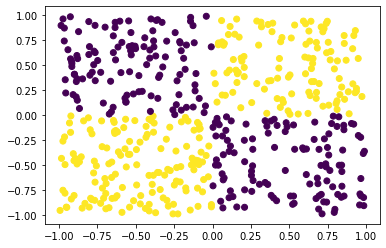

In [93]:
# make XOR gate dataset
N = 500
data = np.random.uniform(-1, 1, (N, 2))
label = np.zeros(N)
label[np.logical_and(data[:, 0] > 0, data[:, 1] > 0)] = 1
label[np.logical_and(data[:, 0] < 0, data[:, 1] < 0)] = 1
label[np.logical_and(data[:, 0] > 0, data[:, 1] < 0)] = 0
label[np.logical_and(data[:, 0] < 0, data[:, 1] > 0)] = 0

# plot the dataset

plt.scatter(data[:, 0], data[:, 1], c=label)
data = torch.tensor(data).float()
label = torch.tensor(label).float().unsqueeze(1)

data.shape, label.shape

### 1-2 Spiral Data
- This is another example of 2D binary classification

In [94]:

# make spiral data
# https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
N = 500
noise_weight = 1.0
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
data_a = data_a + np.random.randn(N,2) * noise_weight

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
data_b = data_b + np.random.randn(N,2) * noise_weight

data = np.append(data_a, data_b, axis=0)
label = np.append(np.zeros(N), np.ones(N))

randomize_order = np.random.permutation(len(data))
data = data[randomize_order] # shuffle
label = label[randomize_order] # shuffle label with same order

data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float().unsqueeze(1)


data.shape, label.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

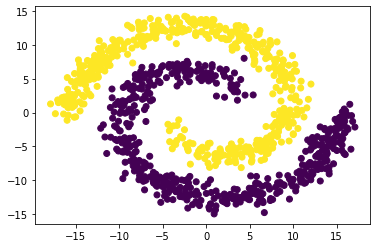

In [95]:
plt.scatter(data[:,0], data[:,1], c=label)

In [96]:
# Function for visualizing decision boundary of the model
def visualize_decision_boundary(model, data, label):
  x_linspace = torch.linspace(min(data[:,0]), max(data[:,0]), steps=200)
  y_linspace = torch.linspace(min(data[:,1]), max(data[:,1]), steps=200)
  grid_x, grid_y = torch.meshgrid(x_linspace, y_linspace)
  grid_xy = torch.stack([grid_x, grid_y]).permute(1,2,0)
  grid_xy = grid_xy.view(-1, 2)
  value_by_grid = model(grid_xy)
  value_by_grid = value_by_grid.view(200, 200, 1)
  value_by_grid[value_by_grid<=0.5] = 0
  value_by_grid[value_by_grid>0.5] = 1

  plt.scatter(x=data[label[:,0]==0,0], y=data[label[:,0]==0,1])
  plt.scatter(x=data[label[:,0]==1,0], y=data[label[:,0]==1,1])

  plt.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), value_by_grid.detach().numpy().squeeze(), alpha=0.3)

## 2. Inspect Dataset

In [97]:
# Print the shape of the data and label
data.shape, label.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [98]:
# Print the first 10 data
# Each data has two features
data[:10]

tensor([[  0.2947,   4.6743],
        [ -4.9183, -10.5568],
        [ -9.1164,  -1.6042],
        [  3.9512,  11.8000],
        [  7.1298,  -6.0329],
        [ -3.9009,  12.3562],
        [  0.0781,   5.0803],
        [  5.2157,  -7.3183],
        [ 13.7660,  -8.2977],
        [  9.3838,   5.2110]])

In [99]:
# Print the first 10 label
# Each label has one value, either 0 or 1
label[:10]

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [100]:
# Let's check how many different category exists in our label
# To count the number of unique element, you can use set()
label_list = label.squeeze().tolist() # convert tensor to list
print(f"First 10 labels: {label_list[:10]}")
print(f"set: {set(label_list)}")
print(f"Using torch unique: {torch.unique(label)}") # You can do the same thing with torch.unique

First 10 labels: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0]
set: {0.0, 1.0}
Using torch unique: tensor([0., 1.])


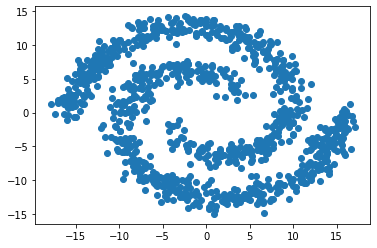

In [101]:
# scatter only for label 0

# first, plot the entire data
plt.scatter(x=data[:,0], y=data[:,1])

In [102]:
# using boolean
is_zero = label == 0
print(label[:10])
print(is_zero[:10])

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.]])
tensor([[ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False]])


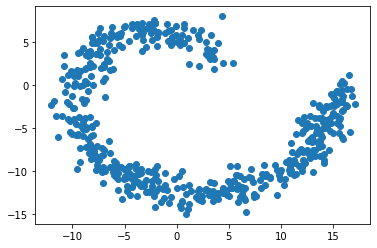

In [103]:
data_zero_class = data[is_zero.squeeze()] # you can index tensor using boolean tensor
plt.scatter(data_zero_class[:,0], data_zero_class[:,1])

In [104]:
# Let's make a model that takes 2D input, and returns 1D output
# f(x1, x2) -> y (between 0 and 1)
import torch.nn as nn

class MyModel(nn.Module):
  def __init__(self):
    super().__init__() # initialize the super class, nn.Module

    self.layer = nn.Linear(2, 32)
    self.layer2 = nn.Linear(32, 1)

  def forward(self, x): # in nn.Module, forward() is the fucntion when is called (__call__)
    # return self.layer2(self.layer(x).relu()).sigmoid()
    x = self.layer(x)
    x = x.relu() # a tensor has method .relu()
    # x = x.sigmoid()
    x = self.layer2(x)
    x = x.sigmoid() # tensor has method .sigmoid(). same with torch.sigmoid(atensor)
    return x


model = MyModel()
out = model(data)

# data.shape, out.shape
out[:10]

tensor([[0.7403],
        [0.3331],
        [0.8882],
        [0.8778],
        [0.2032],
        [0.9473],
        [0.7593],
        [0.1773],
        [0.0900],
        [0.7583]], grad_fn=<SliceBackward0>)

In [105]:
label = label.reshape(-1, 1)

In [106]:
out[:10], label[:10], (out-label).abs()[:10]

(tensor([[0.7403],
         [0.3331],
         [0.8882],
         [0.8778],
         [0.2032],
         [0.9473],
         [0.7593],
         [0.1773],
         [0.0900],
         [0.7583]], grad_fn=<SliceBackward0>),
 tensor([[0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.]]),
 tensor([[0.7403],
         [0.3331],
         [0.8882],
         [0.1222],
         [0.7968],
         [0.0527],
         [0.7593],
         [0.8227],
         [0.0900],
         [0.2417]], grad_fn=<SliceBackward0>))

In [124]:

model = MyModel()
# define optimizer
# optimizer helps you to update the model's parameter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # define what parameters we want to optimizer

for i in range(300):
  # make prediction with current model
  pred = model(data)

  # calculate the loss
  loss = (pred - label).abs().mean()

  # backpropagate the loss
  loss.backward()

  # update the parameter
  optimizer.step()

  # reset the gradient
  # erase the old gradient
  optimizer.zero_grad()
  if (i % 100) == 0:  # for every 100 steps
    print(loss.item())


0.5457748770713806
0.28403323888778687
0.14864084124565125


In [108]:
pred[-10:]

tensor([[    1.0000],
        [    1.0000],
        [    1.0000],
        [    0.0000],
        [    0.0001],
        [    0.9999],
        [    0.9971],
        [    1.0000],
        [    0.0000],
        [    0.0000]], grad_fn=<SliceBackward0>)

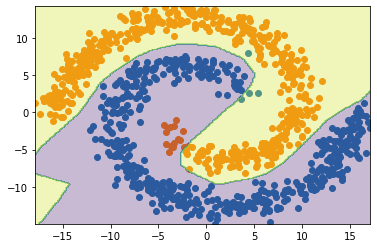

In [125]:
visualize_decision_boundary(model, data, label)


## 4. Using Different Loss
- Binary Cross Entropy
  - Cross Entropy measures the average number of bits (amount of information) needed to identify an event drawn from the set if a coding scheme used for the set is optimized for an estimated probability distribution $q$, rather than the true distribution $p$
    - If the two distributions are same, the cross entropy becomes the minimum value, original entropy
      - In supervised-learning such as classification task, the original entropy is zero, so minimum cross entropy is zero

    - If the two distributions are different, the cross entropy becomes larger
  - Binary cross entropy compares when there is only one probability on binary class.
  - $L = -\frac{1}{N}\sum_{n=1}^N y_n\log(\hat{y}_n) + (1-y_n)\log(1-\hat{y}_n)$
    - $y_n$: true label
    - $\hat{y}_n$: predicted label

  - $\hat{y}$ is usually output of sigmoid function
  - sigmoid function: $y = \frac{1}{1+e^{-x}}$


In [120]:
# binary cross entropy
def binary_cross_entropy(pred, target, eps=1e-7):
  return -(target * torch.log(pred+ eps) + (1-target) * torch.log(1-pred+ eps)).mean()


binary_cross_entropy(out, label)
# xs = torch.linspace(0.0001, 0.99999, 100)
# plt.plot(xs, -torch.log((1-xs)))
# plt.plot(xs, -torch.log(xs))

tensor(0.6591, grad_fn=<NegBackward0>)

In [111]:
def sigmoid(x: torch.Tensor):
  return 1 / (1+ torch.exp(-x))

dummy = torch.randn(7) # random number sampled from normal distribution (Gaussian Distribution)
print(dummy)
print(torch.exp(-dummy))
sigmoid(dummy)

tensor([ 0.5664, -0.1416, -0.1688,  1.2539, -1.0422, -0.8231, -0.6866])
tensor([0.5676, 1.1521, 1.1839, 0.2854, 2.8355, 2.2775, 1.9869])


tensor([0.6379, 0.4647, 0.4579, 0.7780, 0.2607, 0.3051, 0.3348])

In [112]:
xs = torch.linspace(-10, 10, 100)
xs

tensor([-10.0000,  -9.7980,  -9.5960,  -9.3939,  -9.1919,  -8.9899,  -8.7879,
         -8.5859,  -8.3838,  -8.1818,  -7.9798,  -7.7778,  -7.5758,  -7.3737,
         -7.1717,  -6.9697,  -6.7677,  -6.5657,  -6.3636,  -6.1616,  -5.9596,
         -5.7576,  -5.5556,  -5.3535,  -5.1515,  -4.9495,  -4.7475,  -4.5455,
         -4.3434,  -4.1414,  -3.9394,  -3.7374,  -3.5354,  -3.3333,  -3.1313,
         -2.9293,  -2.7273,  -2.5253,  -2.3232,  -2.1212,  -1.9192,  -1.7172,
         -1.5152,  -1.3131,  -1.1111,  -0.9091,  -0.7071,  -0.5051,  -0.3030,
         -0.1010,   0.1010,   0.3030,   0.5051,   0.7071,   0.9091,   1.1111,
          1.3131,   1.5152,   1.7172,   1.9192,   2.1212,   2.3232,   2.5253,
          2.7273,   2.9293,   3.1313,   3.3333,   3.5354,   3.7374,   3.9394,
          4.1414,   4.3434,   4.5455,   4.7475,   4.9495,   5.1515,   5.3535,
          5.5556,   5.7576,   5.9596,   6.1616,   6.3636,   6.5657,   6.7677,
          6.9697,   7.1717,   7.3737,   7.5758,   7.7778,   7.97

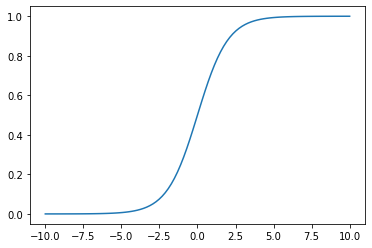

In [113]:
plt.plot(xs, sigmoid(xs))

In [114]:
sigmoid(torch.tensor([0]))

tensor([0.5000])

1.167227029800415
0.31114885210990906
0.06533351540565491


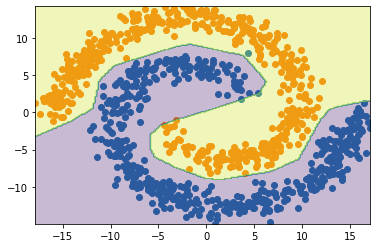

In [123]:
model = MyModel()
# define optimizer
# optimizer helps you to update the model's parameter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # define what parameters we want to optimizer

for i in range(300):
  # make prediction with current model
  pred = model(data)

  # calculate the loss
  loss = binary_cross_entropy(pred, label)

  # backpropagate the loss
  loss.backward()

  # update the parameter
  optimizer.step()

  # reset the gradient
  # erase the old gradient
  optimizer.zero_grad()
  if (i % 100) == 0:  # for every 100 steps
    print(loss.item())

visualize_decision_boundary(model, data, label)


In [141]:
torch.set_printoptions(sci_mode=True)
torch.tensor([1e-45]), torch.tensor([1e-46])

(tensor([1.4013e-45]), tensor([0.]))

In [136]:
torch.log(torch.tensor([1e-46]))

tensor([-inf])